### (PSL) Coding Assignment 2

#### Member
| Field         | Value                |
|---------------|----------------------|
| Name          | Lee Yu Chung, Paul   |
| UID           | 665451160            |
| NetID         | ycl7                 |
| Program       | MCS-DS               |
| Contributions | 100%                 |



### Part I: Implement Lasso

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# set random seed
np.random.seed(1160)

### Load Data


### One-variable Lasso

First, write a function `one_var_lasso` that takes the following inputs:

$$
\mathbf{v} = (v_1, \ldots, v_n)^t, \quad \mathbf{z} = (z_1, \ldots, z_n)^t, \quad \lambda > 0 
$$

and solves the following one-variable Lasso problem:

$$
\min_b \frac{1}{2n} \sum_{i=1}^n (v_i - b z_i)^2 + \lambda |b| = \min_b \frac{1}{2n} \|\mathbf{v} - b \cdot \mathbf{z}\|^2 + \lambda |b|.
$$

Check the [derivation](./OneVarLasso.pdf) for one-variable lasso.

In [3]:
myData = pd.read_csv("dataset/Coding2_Data0.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [4]:
X.shape, len(y)

((506, 13), 506)

### CD for Lasso

In [5]:
def one_var_lasso(r, x, lam):
    
    #################
    # Your CODE
    #################
    
    n = len(r)
    
    x_norm_sq = np.linalg.norm(x) ** 2
    alpha = np.dot(r.T, x) / x_norm_sq
    eta_2 = n * lam / x_norm_sq
    
    if alpha > eta_2:
        return alpha - eta_2
    elif alpha < -eta_2:
        return alpha + eta_2
    else:
        return 0

In [6]:
def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 
    ##############################
    
    # Record the centers and scales used in (1) 
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    
    # Standardize the design matrix X
    newX = (X - X_mean) / X_std

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y

    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[0, ]
    ##############################
    
    # Scale back the coefficients
    B[1:, :] = B[1:, :] / X_std.reshape(-1, 1)
    
    # Update the intercepts stored in B[0, :]
    B[0, :] = np.mean(y) - np.dot(np.mean(X, axis=0), B[1:, :])
    
    
    return(B)

In [7]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.30999458351285664, 0.49974219884804877)

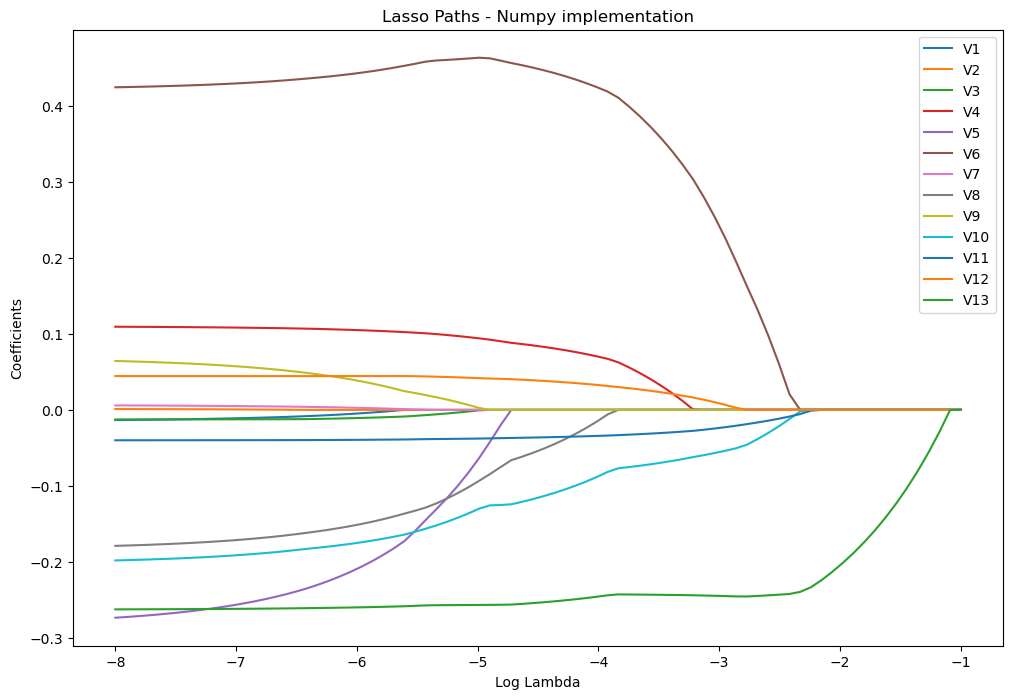

In [8]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

### Check the Accuracy

Compare the accuracy of your algorithm against the output from glmnet. The maximum difference between the two coefficient matrices should be less than 0.005.

In [9]:
lasso_coef = pd.read_csv("dataset/Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [10]:
abs(myout - lasso_coef).max()

0.004645317415932659

### Part II: Simulation Study

Remarks: [Regularization Parameters in Ridge/Lasso Across Different Packages](https://campuswire.com/c/GB46E5679/feed/43)

> To proceed, just pick one option. Before running the 50 iterations, use the full dataset, specify an initial range of lambda/alpha (e.g., the default range), and generate a CV plot. Ensure the plot shows a shape like '\ /' or '__/', indicating that the CV curve covers the minimum point. If the CV curve increases or decreases monotonically, reset the range and generate the plot again. Once you have identified an appropriate range, stick with it for the 50 iterations, and everything should work fine.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

### Load Data

In [12]:
# url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data1.csv"
url = "dataset/Coding2_Data1.csv"
myData = pd.read_csv(url)
# myData.head()
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [13]:
X.shape, len(Y)

((506, 91), 506)

In [14]:
n = len(Y)
indices = np.arange(0, n)
np.random.shuffle(indices)
test_ind = indices[:int(np.floor(0.25*n))]
train_ind = indices[len(test_ind):]

# Splitting the data into training and testing sets
X_train = X.iloc[train_ind]
Y_train = Y[train_ind]
X_test = X.iloc[test_ind]
Y_test = Y[test_ind]

In [15]:
# For RidgeCV and LassoCV, we need to standardize the data
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

### Full Model

In [16]:
full = lm().fit(X_train, Y_train)
mean_squared_error(Y_test, full.predict(X_test))

0.025002576715874983

### Ridge Regression

In [17]:
ridge_alphas = np.logspace(-10, 1, 100) * n

# RidgeCV
ridgecv = RidgeCV(alphas=ridge_alphas, cv=10, scoring='neg_mean_squared_error')
ridgecv.fit(X_train_std, Y_train)

cv_alpha = ridgecv.alpha_
print(cv_alpha)

0.18184697138851405


In [18]:
ridge = Ridge(alpha = cv_alpha)
ridge.fit(X_train_std, Y_train)
mean_squared_error(Y_test, ridge.predict(X_test_std))

0.0265915604246167

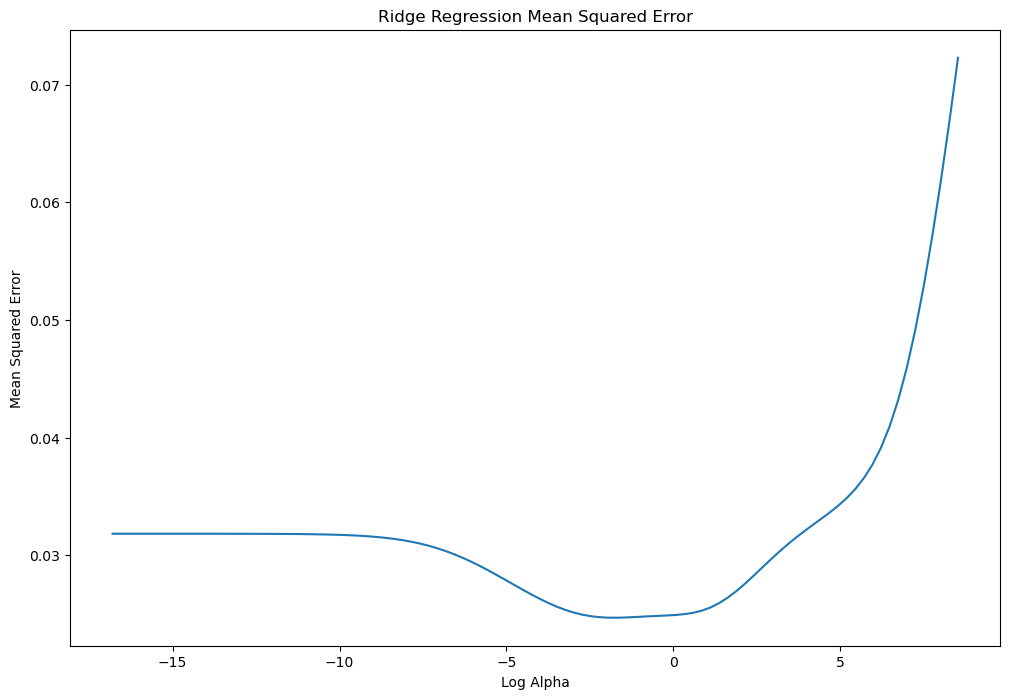

In [19]:
from sklearn.model_selection import cross_val_score

# Generate a CV plot to verify the lamda selection range
# x: log(alpha)
# y: mean_squared_error

mse_scores = []
for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha)
    mse = -cross_val_score(ridge, X_train_std, Y_train, cv=10, scoring='neg_mean_squared_error')
    mse_scores.append(np.mean(mse))

plt.figure(figsize=(12, 8))
plt.plot(np.log(ridge_alphas), mse_scores)
plt.xlabel('Log Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression Mean Squared Error')
plt.axis('tight')
plt.show()

### Lasso

You may encounter convergence warnings while running the code. If you find these warnings distracting, they can be suppressed.

In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [21]:
lasso_alphas = np.logspace(-10, 1, 100)
lassocv = LassoCV(alphas=lasso_alphas, cv=10)
lassocv.fit(X_train_std, Y_train)
cv_alpha = lassocv.alpha_
print(cv_alpha)

0.0001


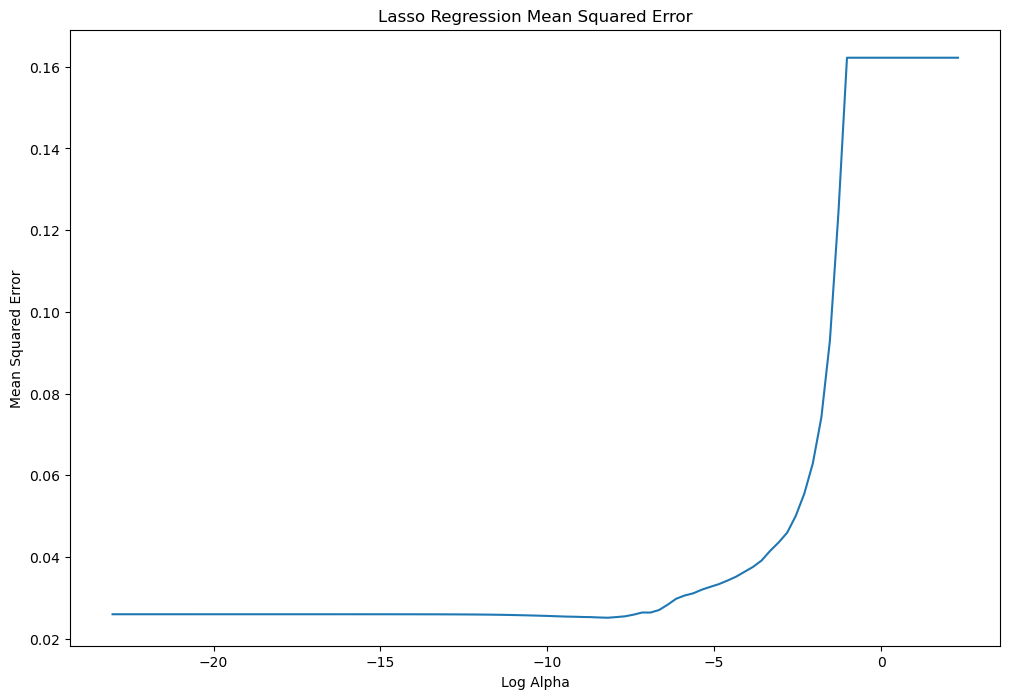

In [22]:
# Generate a CV plot to verify the lamda selection range
# x: log(alpha)
# y: mean_squared_error

mse_scores = []
for alpha in lasso_alphas:
    lasso = Lasso(alpha=alpha)
    mse = -cross_val_score(lasso, X_train_std, Y_train, cv=10, scoring='neg_mean_squared_error')
    mse_scores.append(np.mean(mse))

plt.figure(figsize=(12, 8))
plt.plot(np.log(lasso_alphas), mse_scores)
plt.xlabel('Log Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Regression Mean Squared Error')
plt.axis('tight')
plt.show()

In [23]:
mean_mse = np.mean(lassocv.mse_path_, axis=1)
std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 

cv_alphas = lassocv.alphas_
min_idx = np.argmin(mean_mse)

alpha_min = cv_alphas[min_idx]

threshold = mean_mse[min_idx] + std_mse[min_idx]
alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

alpha_min, alpha_1se  #alpha_min = lassocv.alpha_

(0.0001, 0.0012915496650148827)

Lasso with alpha_min

In [24]:
lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
lasso_model_min.fit(X_train_std, Y_train)
mean_squared_error(Y_test, lasso_model_min.predict(X_test_std))

0.02736394836749869

Lasso with alpha_1se



In [25]:
lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
lasso_model_1se.fit(X_train_std, Y_train)
mean_squared_error(Y_test, lasso_model_1se.predict(X_test_std))

0.03540496747975392

Refit with alpha_1se



In [26]:
nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
lm_refit = lm()
lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)
mean_squared_error(Y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices]))

0.03277182766915184

### PCR

This sample code demonstrates the implementation of Principal Component Regression (PCR) using 10-fold cross-validation for selecting the optimal number of components. In the provided code, it is assumed that both `X` and `Y` are NumPy arrays. Additionally, scikit-learn's Linear Regression is imported and abbreviated as `lm`.

In [27]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            # train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            train_inds = np.concatenate(index_sets[:ifold] + index_sets[ifold+1:]).astype(int)
            test_inds = index_sets[ifold].astype(int)

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [28]:
pcr = PCR()
pcr.fit(X_train.to_numpy(), Y_train.to_numpy())
mean_squared_error(Y_test, pcr.predict(X_test.to_numpy()))

0.029929682735422822

Consider the following six procedures:
- Full: Fit a linear regression model using all features
- Ridge.min: Ridge regression using lambda.min
- Lasso.min: Lasso regression using lambda.min
- Lasso.1se: Lasso regression using lambda.1se
- L.Refit: Refit the model selected by Lasso using lambda.1se
- PCR: principle components regression with the number of components chosen by 10-fold cross validation

### Case 1

Download the data set Coding2_Data1.csv. The first 14 columns are the same as the data set we used in Part I with Y being the response variable (moved to the 1st column). The additional 78 more predictors are the quadratic and pairwise product terms of the original 13 predictors.

[a] Conduct the following simulation exercise 50 times:
- In each iteration, randomly split the data into two parts, 75% for training and 25% for testing.
- For each of the six procedures, train a model using the training subset and generate predictions for the test subset. Record the MSPE (Mean Squared Prediction Error) based on these test data predictions.

[b] Graphically summarize your findings on the MSPE using a strip chart, and consider overlaying a boxplot for additional insights.

[c] Based on the outcomes of your simulation study, please address the following questions:
- Which procedure or procedures yield the best performance in terms of MSPE?
- Conversely, which procedure or procedures show the poorest performance?
- In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?
- Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?
- Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?


In [29]:
# Load the data
url = "dataset/Coding2_Data1.csv"
myData = pd.read_csv(url)
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

# Record the MSPE (Mean Squared Prediction Error) for each procedure
mspe = {
    'full': [],
    'ridge': [],
    'lasso_min': [],
    'lasso_1se': [],
    'lasso_refit': [],
    'pcr': []
}

In [30]:
# set the random seed
from joblib import Parallel, delayed
np.random.seed(1160)


def run_iteration(i):
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i)

    # For RidgeCV and LassoCV, we need to standardize the data
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    results = {}

    # 1. Full model
    full = lm().fit(X_train, Y_train)
    results['full'] = mean_squared_error(Y_test, full.predict(X_test))

    # 2. Ridge regression
    ridge_alphas = np.logspace(-10, 1, 100) * n
    ridgecv = RidgeCV(alphas=ridge_alphas, cv=10,
                      scoring='neg_mean_squared_error')
    ridgecv.fit(X_train_std, Y_train)

    ridge = Ridge(alpha=ridgecv.alpha_)
    ridge.fit(X_train_std, Y_train)
    results['ridge'] = mean_squared_error(Y_test, ridge.predict(X_test_std))

    # 3. Lasso.min and Lasso.1se
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas=lasso_alphas, cv=10)
    lassocv.fit(X_train_std, Y_train)

    # compute the alpha.min and alpha.1se
    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10)

    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)

    alpha_min = cv_alphas[min_idx]

    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

    # Lasso with alpha_min
    lasso_model_min = Lasso(alpha=alpha_min, max_iter=10000)
    lasso_model_min.fit(X_train_std, Y_train)
    results['lasso_min'] = mean_squared_error(
        Y_test, lasso_model_min.predict(X_test_std))

    # Lasso with alpha_1se
    lasso_model_1se = Lasso(alpha=alpha_1se, max_iter=10000)
    lasso_model_1se.fit(X_train_std, Y_train)
    results['lasso_1se'] = mean_squared_error(
        Y_test, lasso_model_1se.predict(X_test_std))

    # 4. L.Refit
    nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
    lm_refit = lm()
    lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)
    results['lasso_refit'] = mean_squared_error(
        Y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices]))

    # 5. PCR
    pcr = PCR()
    pcr.fit(X_train.to_numpy(), Y_train.to_numpy())
    results['pcr'] = mean_squared_error(Y_test, pcr.predict(X_test.to_numpy()))

    return results


# Conduct the simulation exercise 50 times
results = Parallel(n_jobs=-1)(delayed(run_iteration)(i) for i in range(50))

# Aggregate the results
mspe = {key: [result[key] for result in results] for key in results[0]}

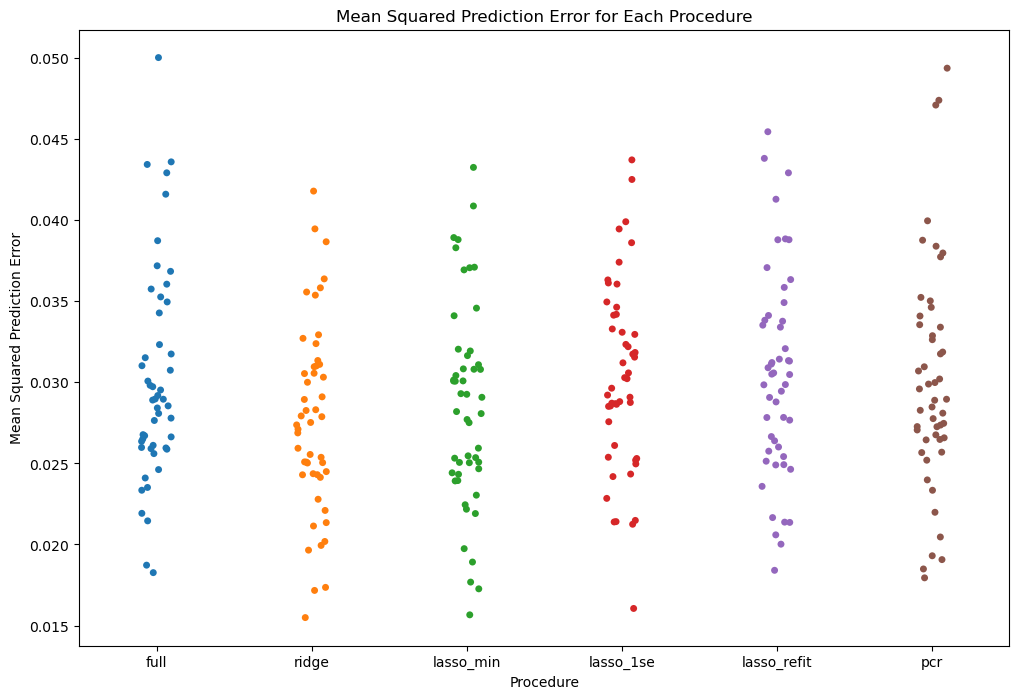

In [94]:
# summarize your findings on the MSPE using a strip chart and overlaying boxplot
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.stripplot(data=mspe)

plt.xlabel('Procedure')
plt.ylabel('Mean Squared Prediction Error')
plt.title('Mean Squared Prediction Error for Each Procedure')
plt.show()


In [64]:
import pprint as pp
mspe_mean = {key: np.mean(mspe[key]) for key in mspe}
print("The mean of MSPE for each procedure is: ")
pp.pprint(mspe_mean)
print()
print("Q: Which procedure or procedures yield the best performance in terms of MSPE?")
print(f"{min(mspe_mean, key=mspe_mean.get)} yielding the smallest mean MSPE: {min(mspe_mean.values())}")
print()

print("Q: Conversely, which procedure or procedures show the poorest performance?")
print(f"{max(mspe_mean, key=mspe_mean.get)} yielding the largest mean MSPE: {max(mspe_mean.values())}")
print()

print("Q: In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?")
print(f"Lasso.min: {mspe_mean['lasso_min']}")
print(f"Lasso.1se: {mspe_mean['lasso_1se']}")
better_lasso = 'lasso_min' if mspe_mean['lasso_min'] < mspe_mean['lasso_1se'] else 'lasso_1se'
print(f"{better_lasso} yields a better MSPE: {min(mspe_mean['lasso_min'], mspe_mean['lasso_1se'])}")
print()


print("Q: Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?")
print(f"L.Refit: {mspe_mean['lasso_refit']}")
print(f"Lasso.1se: {mspe_mean['lasso_1se']}")
refit_outperform = mspe_mean['lasso_refit'] < mspe_mean['lasso_1se']
print("L.Refit outperforms Lasso.1se" if refit_outperform else "Lasso.1se outperforms L.Refit")
print()

print("Q: Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?")
print(f"Full model: {mspe_mean['full']}")
print(f"Since {min(mspe_mean, key=mspe_mean.get)} is the best-performing procedure with mean MSPE: {min(mspe_mean.values())}")
full_comparable = abs(mspe_mean['full'] - min(mspe_mean.values())) < 1e-6
print("The performance of the Full model is comparable to, or divergent from, the best-performing procedure among the other five" if full_comparable else "The performance of the Full model is divergent from the best-performing procedure among the other five")

The mean of MSPE for each procedure is: 
{'full': 0.030152658479710798,
 'lasso_1se': 0.03033465958625091,
 'lasso_min': 0.028520828559978516,
 'lasso_refit': 0.03040977902794076,
 'pcr': 0.030139626527058344,
 'ridge': 0.027636319881526695}

Q: Which procedure or procedures yield the best performance in terms of MSPE?
ridge yielding the smallest mean MSPE: 0.027636319881526695

Q: Conversely, which procedure or procedures show the poorest performance?
lasso_refit yielding the largest mean MSPE: 0.03040977902794076

Q: In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?
Lasso.min: 0.028520828559978516
Lasso.1se: 0.03033465958625091
lasso_min yields a better MSPE: 0.028520828559978516

Q: Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?
L.Refit: 0.03040977902794076
Lasso.1se: 0.03033465958625091
Lasso.1se outperforms L.Refit

Q: Is variable selection or shrinkage warranted for this particular datase

### Case II

Download the data set Coding2_Data2.csv. The first 92 columns are identical to those in Coding2_Data1.csv, with the addition of 500 columns of artificially generated noise features.

- Repeat [a] and [b] above for the five procedures excluding the Full procedure. Graphically summarize your findings on MSPE using a strip chart, and consider overlaying a boxplot for additional insights.
- [c] Address the following questions:
  - Which procedure or procedures yield the best performance in terms of MSPE?
  - Conversely, which procedure or procedures show the poorest performance?
  - Have you observed any procedure or procedures that performed well in Case I but exhibited poorer performance in Case II, or vice versa? If so, please offer an explanation.
  - Given that Coding2_Data2.csv includes all features found in Coding2_Data1.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case I. Do your simulation results corroborate this expectation? If not, please offer an explanation.